In [105]:
import math
import numpy as np
from matplotlib import pyplot as plt
import copy
import gif
from IPython.display import Image


In [106]:
def animate(data, j, patch, head, joints):
    first = []
    second = []
    for i in joints:
        first.append(data[j][0][i])
        second.append(data[j][1][i])
    a = np.array([first, second])
    a = np.transpose(a)
    patch.set_xy(a)
    head.center = (data[j][0][5], data[j][1][5])
    return patch, head

# To create a gif image
@gif.frame
def plot_samples_normal(data, j):
    # draw the simulation
    fig = plt.figure()
    fig.set_dpi(100)
    fig.set_size_inches(12, 3)

    ax = plt.axes(xlim=(-1, 10), ylim=(-0.1, 3))


    joints = [5, 0, 1, 2, 1, 0, 3, 4]
    patch = plt.Polygon([[0, 0], [0, 0]], closed=None, fill=None, edgecolor="k")
    head = plt.Circle((0, 0), radius=0.15, fc="k", ec="k")
    ax.add_patch(patch)
    ax.add_patch(head)
    plt.title(f"total_distance: {data[j][0][5]:.2f}")
    animate(data, j, patch, head, joints)
    # ax.Line2D([-0.5, 0], [10, 0], color='black')

    step_size = 11 / len(data)

    # Add a progress bar rectangle at the bottom
    progress_bar_height = 0.1
    progress_bar_y = -0.1  # Position of the progress bar on the y-axis
    progress_bar = plt.Rectangle((-1, progress_bar_y), step_size*j, progress_bar_height, color='blue')
    ax.add_patch(progress_bar)

    # Add a border for the progress bar
    progress_bar_border = plt.Rectangle((-1, progress_bar_y), 11, progress_bar_height, fill=False, edgecolor='black', linewidth=1)
    ax.add_patch(progress_bar_border)



In [107]:
# plan is an array of 40 floating point numbers
def sim(plan):
    """
    Simulates the motion of a multi-jointed body based on a given plan.

    Parameters:
    plan (list of float): A list of control parameters for the simulation. Each element should be between -1 and 1.

    Returns:
    tuple:
        - data (list of list of list of float): A list of positions of the body parts at each time step. Each position is a list of two lists, representing the x and y coordinates of the body parts.
        - final_position (float): The final x-coordinate of the head (body part 5).

    The simulation involves:
    - Adjusting the control parameters to be within the range [-1, 1].
    - Initializing physical properties such as mass, edge lengths, spring constants, and damping factors.
    - Iteratively updating the positions and velocities of the body parts based on forces, torques, and constraints.
    - Handling contact with the ground and applying friction.
    - Recording the positions of the body parts at each time step.
    - Returning the recorded data and the final x-coordinate of the head.
    """
    for i in range(0, len(plan)):
        if plan[i] > 1:
            plan[i] = 1.0
        elif plan[i] < -1:
            plan[i] = -1.0

    dt = 0.1 # time step
    friction = 1.0 # friction coefficient
    gravity = 0.1 # gravity constant
    mass = [30, 10, 5, 10, 5, 10] # mass of body parts
    edgel = [0.5, 0.5, 0.5, 0.5, 0.9] # edge lengths
    edgesp = [160.0, 180.0, 160.0, 180.0, 160.0]    # spring constants
    edgef = [8.0, 8.0, 8.0, 8.0, 8.0]   # damping factors
    anglessp = [20.0, 20.0, 10.0, 10.0] # angular spring constants
    anglesf = [8.0, 8.0, 4.0, 4.0]  # angular damping factors

    edge = [(0, 1), (1, 2), (0, 3), (3, 4), (0, 5)] # edges
    angles = [(4, 0), (4, 2), (0, 1), (2, 3)] # angles

    # vel and pos of the body parts, 0 is hip, 5 is head, others are joints
    v = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
    p = [[0, 0, -0.25, 0.25, 0.25, 0.15], [1, 0.5, 0, 0.5, 0, 1.9]]

    spin = 0.0
    maxspin = 0.0
    lastang = 0.0

    data = []

    for j in range(20): # 20 time steps
        for k in range(10): # 10 substeps
            lamb = 0.05 + 0.1 * k 
            t0 = 0.5
            if j > 0:
                t0 = plan[2 * j - 2]
            t0 *= 1 - lamb
            t0 += plan[2 * j] * lamb

            t1 = 0.0
            if j > 0:
                t1 = plan[2 * j - 1]
            t1 *= 1 - lamb
            t1 += plan[2 * j + 1] * lamb

            contact = [False, False, False, False, False, False]
            for z in range(6):
                if p[1][z] <= 0:
                    contact[z] = True
                    spin = 0
                    p[1][z] = 0

            anglesl = [-(2.8 + t0), -(2.8 - t0), -(1 - t1) * 0.9, -(1 + t1) * 0.9] 

            disp = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            dist = [0, 0, 0, 0, 0]
            dispn = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            for z in range(5):
                disp[0][z] = p[0][edge[z][1]] - p[0][edge[z][0]]
                disp[1][z] = p[1][edge[z][1]] - p[1][edge[z][0]]
                dist[z] = (
                    math.sqrt(disp[0][z] * disp[0][z] + disp[1][z] * disp[1][z]) + 0.01
                )
                inv = 1.0 / dist[z]
                dispn[0][z] = disp[0][z] * inv
                dispn[1][z] = disp[1][z] * inv 

            dispv = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            distv = [0, 0, 0, 0, 0]
            for z in range(5):
                dispv[0][z] = v[0][edge[z][1]] - v[0][edge[z][0]]
                dispv[1][z] = v[1][edge[z][1]] - v[1][edge[z][0]]
                distv[z] = 2 * (disp[0][z] * dispv[0][z] + disp[1][z] * dispv[1][z])

            forceedge = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            for z in range(5):
                c = (edgel[z] - dist[z]) * edgesp[z] - distv[z] * edgef[z]
                forceedge[0][z] = c * dispn[0][z]
                forceedge[1][z] = c * dispn[1][z]

            edgeang = [0, 0, 0, 0, 0]
            edgeangv = [0, 0, 0, 0, 0]
            for z in range(5):
                edgeang[z] = math.atan2(disp[1][z], disp[0][z])
                edgeangv[z] = (dispv[0][z] * disp[1][z] - dispv[1][z] * disp[0][z]) / (
                    dist[z] * dist[z]
                )

            inc = edgeang[4] - lastang
            if inc < -math.pi:
                inc += 2.0 * math.pi
            elif inc > math.pi:
                inc -= 2.0 * math.pi
            spin += inc
            spinc = spin - 0.005 * (k + 10 * j)
            if spinc > maxspin:
                maxspin = spinc
                lastang = edgeang[4]

            angv = [0, 0, 0, 0]
            for z in range(4): 
                angv[z] = edgeangv[angles[z][1]] - edgeangv[angles[z][0]]

            angf = [0, 0, 0, 0]
            for z in range(4):
                ang = edgeang[angles[z][1]] - edgeang[angles[z][0]] - anglesl[z]
                if ang > math.pi:
                    ang -= 2 * math.pi
                elif ang < -math.pi:
                    ang += 2 * math.pi
                m0 = dist[angles[z][0]] / edgel[angles[z][0]]
                m1 = dist[angles[z][1]] / edgel[angles[z][1]]
                angf[z] = ang * anglessp[z] - angv[z] * anglesf[z] * min(m0, m1)

            edgetorque = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            for z in range(5):
                inv = 1.0 / (dist[z] * dist[z])
                edgetorque[0][z] = -disp[1][z] * inv
                edgetorque[1][z] = disp[0][z] * inv

            for z in range(4):
                i0 = angles[z][0]
                i1 = angles[z][1]
                forceedge[0][i0] += angf[z] * edgetorque[0][i0]
                forceedge[1][i0] += angf[z] * edgetorque[1][i0]
                forceedge[0][i1] -= angf[z] * edgetorque[0][i1]
                forceedge[1][i1] -= angf[z] * edgetorque[1][i1]

            f = [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
            for z in range(5):
                i0 = edge[z][0]
                i1 = edge[z][1]
                f[0][i0] -= forceedge[0][z]
                f[1][i0] -= forceedge[1][z]
                f[0][i1] += forceedge[0][z]
                f[1][i1] += forceedge[1][z]

            for z in range(6):
                f[1][z] -= gravity * mass[z]
                invm = 1.0 / mass[z]
                v[0][z] += f[0][z] * dt * invm
                v[1][z] += f[1][z] * dt * invm

                if contact[z]:
                    fric = 0.0
                    if v[1][z] < 0.0:
                        fric = -v[1][z]
                        v[1][z] = 0.0

                    s = np.sign(v[0][z])
                    if v[0][z] * s < fric * friction:
                        v[0][z] = 0
                    else:
                        v[0][z] -= fric * friction * s
                p[0][z] += v[0][z] * dt
                p[1][z] += v[1][z] * dt

            data.append(copy.deepcopy(p))

            if contact[0] or contact[5]:
                return data, p[0][5]
    return data, p[0][5]

Evolutionary algorithm

In [108]:
import random
import numpy as np

def evaluate_individual(x):
    data, total_distance = sim(x)
    return total_distance

def initialize_population(population_size, n_genes):
    population = np.zeros((population_size, n_genes), dtype=float)
    for i in range(population_size):
        population[i,:] = [np.random.uniform(-1, 1) for i in range(40)]
    return population

def tournament_select(fitness, p_tournament):
    population_size = len(fitness)
    i_tmp1 = random.randint(0, population_size - 1)
    i_tmp2 = random.randint(0, population_size - 1)
    
    r = random.random()
    
    if r < p_tournament:
        if fitness[i_tmp1] > fitness[i_tmp2]:
            i_selected = i_tmp1
        else:
            i_selected = i_tmp2
    else:
        if fitness[i_tmp1] > fitness[i_tmp2]:
            i_selected = i_tmp2
        else:
            i_selected = i_tmp1
    
    return i_selected

def cross(chromosome1, chromosome2):
    n_genes = len(chromosome1)  
    crossover_point = random.randint(1, n_genes - 1)

    # Initialize the new chromosome pair
    new_chromosome_pair = np.zeros((2, n_genes), dtype=type(chromosome1[0]))

    for j in range(n_genes):
        if j < crossover_point:
            new_chromosome_pair[0][j] = chromosome1[j]
            new_chromosome_pair[1][j] = chromosome2[j]
        else:
            new_chromosome_pair[0][j] = chromosome2[j]
            new_chromosome_pair[1][j] = chromosome1[j]

    return new_chromosome_pair

def mutate(chromosome, mutation_probability):
    n_genes = len(chromosome)
    mutated_chromosome = chromosome.copy()
    mutation_range = 0.3
    
    for j in range(n_genes):
        r = random.random()
        if r < mutation_probability:
            # Add a small perturbation within [-mutation_range, mutation_range]
            perturbation = np.random.uniform(-mutation_range, mutation_range)
            mutated_chromosome[j] += perturbation
            # Ensure the gene stays within the range [-1, 1]
            mutated_chromosome[j] = max(-1, min(1, mutated_chromosome[j]))
    
    return mutated_chromosome



In [109]:
def evolutionary_algorithm():

    # Parameters
    population_size = 120
    number_of_genes = 40
    crossover_probability = 0.8
    mutation_probability = 0.025
    tournament_selection_parameter = 0.75
    variable_range = 3.0
    number_of_generations = 500

    # Initialize fitness
    fitness = np.zeros(population_size)

    # Initialize population
    population = initialize_population(population_size, number_of_genes)

    # Main loop
    for generation in range(number_of_generations):
        maximum_fitness = 0.0
        x_best = np.zeros(2)
        best_individual_index = 0

        # Evaluate fitness
        for i in range(population_size):
            x = population[i, :]
            fitness[i] = evaluate_individual(x)
            if fitness[i] > maximum_fitness:
                maximum_fitness = fitness[i]
                best_individual_index = i
                x_best = x

        # Crossover and mutation
        temp_population = population.copy()
        for i in range(0, population_size, 2):
            i1 = tournament_select(fitness, tournament_selection_parameter)
            i2 = tournament_select(fitness, tournament_selection_parameter)
            chromosome1 = population[i1, :]
            chromosome2 = population[i2, :]

            if random.random() < crossover_probability:
                new_chromosome_pair = cross(chromosome1, chromosome2)
                temp_population[i, :] = new_chromosome_pair[0]
                temp_population[i + 1, :] = new_chromosome_pair[1]
            else:
                temp_population[i, :] = chromosome1
                temp_population[i + 1, :] = chromosome2

        # Apply mutation
        for i in range(population_size):
            temp_population[i, :] = mutate(temp_population[i, :], mutation_probability)

        # Elitism
        temp_population[0, :] = population[best_individual_index, :]
        population = temp_population

        if (generation % 10 == 0):
            print("Generation: ", generation, ", Max fitness: ", maximum_fitness)

    plan = population[0,:]
    return plan

In [110]:
#Evolutionary algorithm
plan = evolutionary_algorithm()

Generation:  0 , Max fitness:  4.56421432125499
Generation:  10 , Max fitness:  4.609355186221376
Generation:  20 , Max fitness:  5.216313717904711
Generation:  30 , Max fitness:  5.618671065582875
Generation:  40 , Max fitness:  6.19529096267434
Generation:  50 , Max fitness:  6.759589337632644
Generation:  60 , Max fitness:  6.826526721517572
Generation:  70 , Max fitness:  6.908779075296186
Generation:  80 , Max fitness:  6.908779075296186
Generation:  90 , Max fitness:  7.1617422553073595


KeyboardInterrupt: 

In [ ]:
data, total_distance = sim(plan)
print("Total Distance = ", total_distance)
print(plan)

Total Distance =  9.327718278413986
[ 0.33527233  0.51339152  0.86811921  0.98348338  0.88071961  0.84710811
 -0.247277   -0.07502614  0.80895983  0.40481003  0.34341584  0.95703424
 -1.         -1.         -0.05844506 -0.93266756  0.935457    0.9750277
  1.          0.70200143  1.          0.90129003  0.11479393  0.8694149
 -0.83700992 -1.          0.66887944 -0.00210863 -1.         -0.64619194
 -0.56032511 -1.          0.94984079  1.         -0.55150518  0.97163177
  0.08673002  0.96609561  0.10790934 -1.        ]


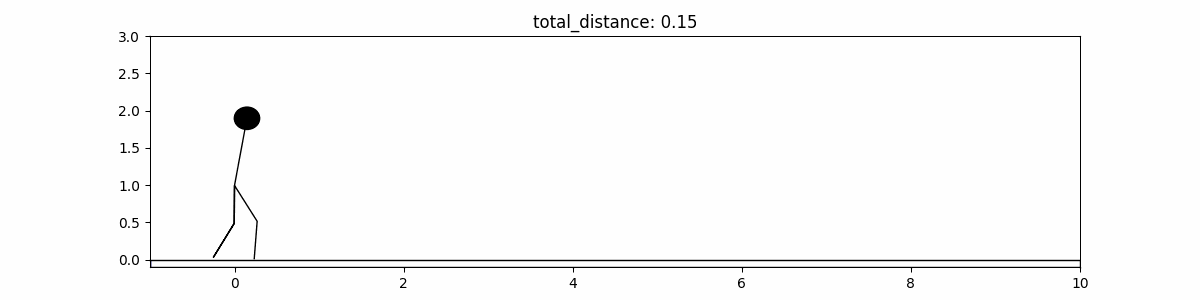

In [ ]:
# Create a gif
frames = []
for j in range(len(data)):
    frame = plot_samples_normal(data, j)
    frames.append(frame)

gif.save(frames, "evolutionary.gif", duration=40)
Image(filename="evolutionary.gif")

Simulated Annealing

In [ ]:
def simulated_annealing(num_steps=5000, initial_temp=10, cooling_rate=0.999):
    current_vector = np.random.uniform(-1, 1, 40)
    current_distance = sim(current_vector)[1]
    best_vector = current_vector
    best_distance = current_distance
    temp = initial_temp

    for step in range(num_steps):
        # Propose a new vector
        proposal = current_vector + np.random.normal(0, 0.1, 40)
        proposal = np.clip(proposal, -1, 1)
        proposal_distance = sim(proposal)[1]

        # Acceptance criterion with temperature
        if np.random.rand() < np.exp((proposal_distance - current_distance) / temp):
            current_vector = proposal
            current_distance = proposal_distance

        # Track the best vector
        if current_distance > best_distance:
            best_vector = current_vector
            best_distance = current_distance

        # Cool down the temperature
        temp *= cooling_rate
        if step % 100 == 0 or step == 0:
            print(f"Step {step + 1}: Distance = {current_distance:.4f}, Temp = {temp:.4f}")

    return best_vector, best_distance

best_vec, best_dist = simulated_annealing()
data, total_distance = sim(best_vec)

Step 1: Distance = -0.7165, Temp = 9.9900
Step 101: Distance = 0.2055, Temp = 9.0389
Step 201: Distance = 0.4882, Temp = 8.1783
Step 301: Distance = -1.4309, Temp = 7.3997
Step 401: Distance = -0.7951, Temp = 6.6952
Step 501: Distance = -0.0007, Temp = 6.0577
Step 601: Distance = -0.9760, Temp = 5.4810
Step 701: Distance = -0.4405, Temp = 4.9592
Step 801: Distance = -1.4358, Temp = 4.4870
Step 901: Distance = 1.2256, Temp = 4.0598
Step 1001: Distance = 1.2600, Temp = 3.6733
Step 1101: Distance = -0.9656, Temp = 3.3236
Step 1201: Distance = -0.0990, Temp = 3.0071
Step 1301: Distance = -0.6704, Temp = 2.7208
Step 1401: Distance = -1.0260, Temp = 2.4618
Step 1501: Distance = -0.0938, Temp = 2.2274
Step 1601: Distance = -0.4413, Temp = 2.0153
Step 1701: Distance = 1.8116, Temp = 1.8235
Step 1801: Distance = 2.8317, Temp = 1.6498
Step 1901: Distance = -0.5956, Temp = 1.4928
Step 2001: Distance = -1.4803, Temp = 1.3506
Step 2101: Distance = 1.3243, Temp = 1.2221
Step 2201: Distance = -0.5534

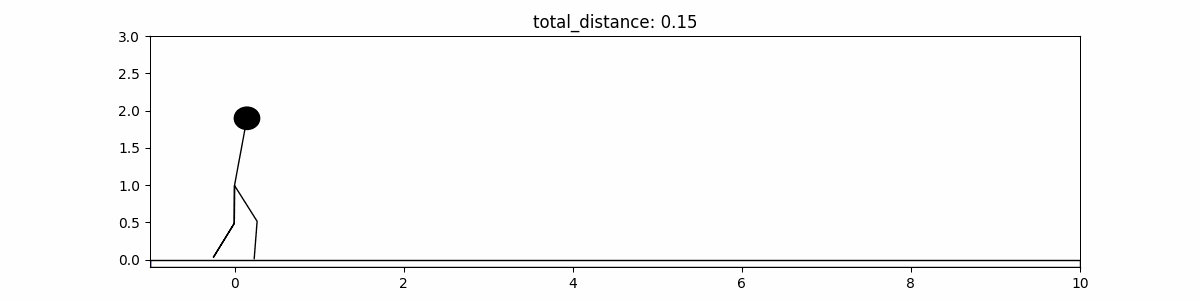

In [ ]:
# Create a gif
frames = []
for j in range(len(data)):
    frame = plot_samples_normal(data, j)
    frames.append(frame)

gif.save(frames, "simulated_annealing.gif", duration=40)
Image(filename="simulated_annealing.gif")

In [ ]:
best_plan_ever = [0.33527233, 0.51339152, 0.86811921, 0.98348338, 0.88071961, 0.84710811,
                  -0.247277, -0.07502614, 0.80895983, 0.40481003, 0.34341584, 0.95703424,
                  -1.0, -1.0, -0.05844506, -0.93266756, 0.935457, 0.9750277,
                  1.0, 0.70200143, 1.0, 0.90129003, 0.11479393, 0.8694149,
                  -0.83700992, -1.0, 0.66887944, -0.00210863, -1.0, -0.64619194,
                  -0.56032511, -1.0, 0.94984079, 1.0, -0.55150518, 0.97163177,
                  0.08673002, 0.96609561, 0.10790934, -1.0]